In [1]:
import cv2
import numpy as np
import skimage.io
import os
import sys
import matplotlib.pyplot as plt
import math
from scipy import ndimage
from collections import Counter
from itertools import permutations 
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

base_data = './data/val/img'

Using TensorFlow backend.


In [2]:
# patent reason
# https://stackoverflow.com/questions/52305578/sift-cv2-xfeatures2d-sift-create-not-working-even-though-have-contrib-instal

In [3]:
def perp(a):
    b = np.empty_like(a)
    b[0], b[1] = -a[1], a[0]
    return b

def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def segment(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def intersect(a1,a2,b1,b2):
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    det = np.dot(perp(da), db)
#      and segment(a1,a2,b1,b2)
    if det != 0 and segment(a1,a2,b1,b2):
        num = np.dot(perp(da), dp)
        res = (num / det.astype(float))*db + b1
        return list(res.astype(int))
    else:
        return [0,0]

def get_res(img):
    def find_intersections(lines):
        inter = []
        perm = permutations(lines, 2) 
        for i in perm:
            x1_1, y1_1, x1_2, y1_2 = i[0][0]
            x2_1, y2_1, x2_2, y2_2 = i[1][0]
            
            p1 = np.array([x1_1, y1_1])
            p2 = np.array([x1_2, y1_2])
            p3 = np.array([x2_1, y2_1])
            p4 = np.array([x2_2, y2_2])

            inter.append(intersect(p1,p2,p3,p4))
        inter = [i for i in inter if i!=[0,0]]
        
        return inter
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    thresh = cv2.adaptiveThreshold(gray, 255, 1, 1, 11, 2)
    label, _ = ndimage.label(thresh, np.ones((3,3)))
    t = (img.shape[0]*img.shape[1]) / 100
    keep = [key for key,value in Counter(label.flatten()).items() if value > t and key!=0]
    for i in keep:
        label = np.where(label!=i, label, -1)
    gray = np.float32(np.where(label==-1, 0, 255))
    label = cv2.cvtColor(gray/255, cv2.COLOR_GRAY2RGB)

    # Detect points that form a line
    gray = np.invert(np.uint8(gray))
    lines = cv2.HoughLinesP(gray, rho=1, theta=np.pi/180, threshold=50, minLineLength=10, maxLineGap=15)

    # Find intersections
    inter = find_intersections(lines)
    cls = DBSCAN(eps=t/45, min_samples=1).fit(np.array(inter))

    centroid = []
    for i in np.unique(cls.labels_):
        idx = np.where(cls.labels_ == i)[0]
        pt = [inter[i] for i in idx]
        centroid.append([np.mean(np.array(pt)[:,0]).astype(int),np.mean(np.array(pt)[:,1]).astype(int)])
    
    # Draw lines on the image
    img_res = img.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        img_res = cv2.line(img_res, (x1, y1), (x2, y2), (255, 0, 0), 1)
    for idx, coord in enumerate(inter):
        x, y = coord
        img_res = cv2.circle(img_res, (x, y), 3, (0, 255, 0), -1)
    for idx, coord in enumerate(centroid):
        x, y = coord
        img_res = cv2.circle(img_res, (x, y), 2, (0, 0, 255), -1)

    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(label)
    plt.subplot(1,3,3)
    plt.imshow(img_res)
    return 

# Clean picture test

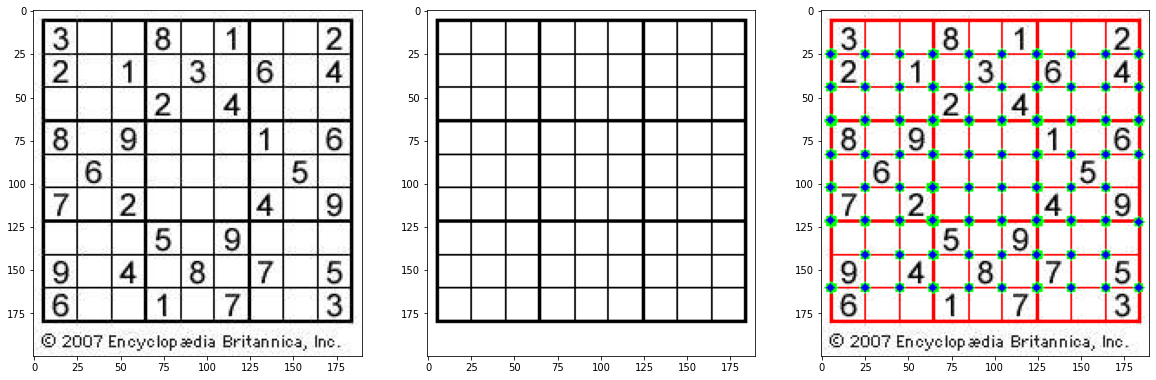

In [4]:
img = cv2.imread(os.path.join(base_data,'clear.jpg'))
label = get_res(img)

# Real picture test

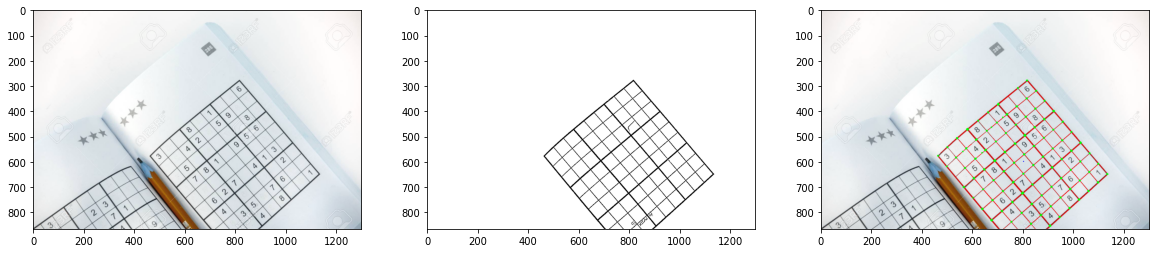

In [5]:
img = cv2.imread(os.path.join(base_data,'book_1.jpg'))
label_1 = get_res(img)

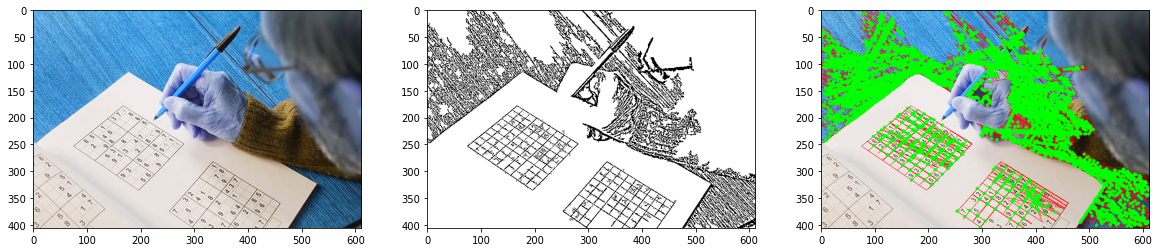

In [6]:
img = cv2.imread(os.path.join(base_data,'book_2.jpg'))
label_2 = get_res(img)

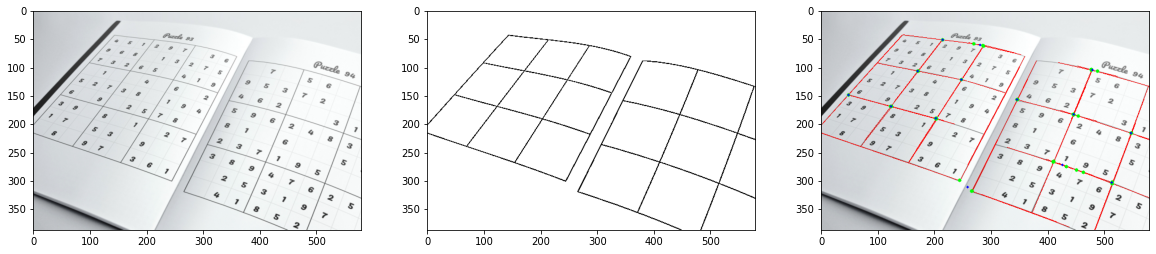

In [7]:
img = cv2.imread(os.path.join(base_data,'book_3.jpg'))
label_3 = get_res(img)

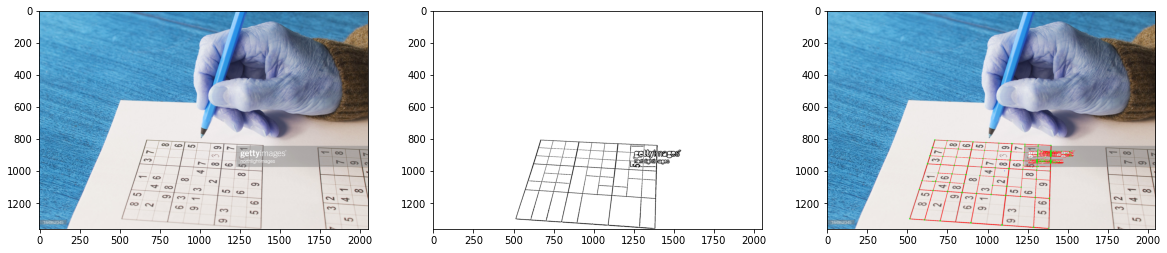

In [8]:
img = cv2.imread(os.path.join(base_data,'book_4.jpg'))
label_4 = get_res(img)

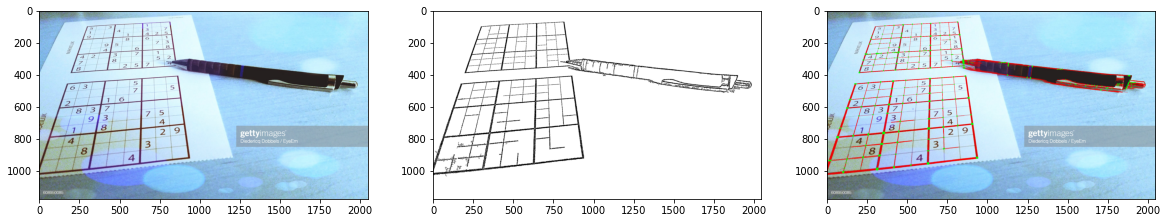

In [9]:
img = cv2.imread(os.path.join(base_data,'book_5.jpg'))
label_5 = get_res(img)

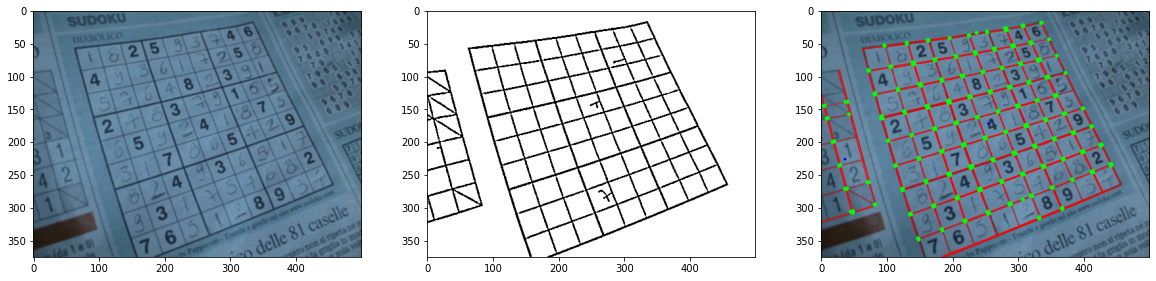

In [10]:
img = cv2.imread(os.path.join(base_data,'book_6.jpg'))
label_6 = get_res(img)

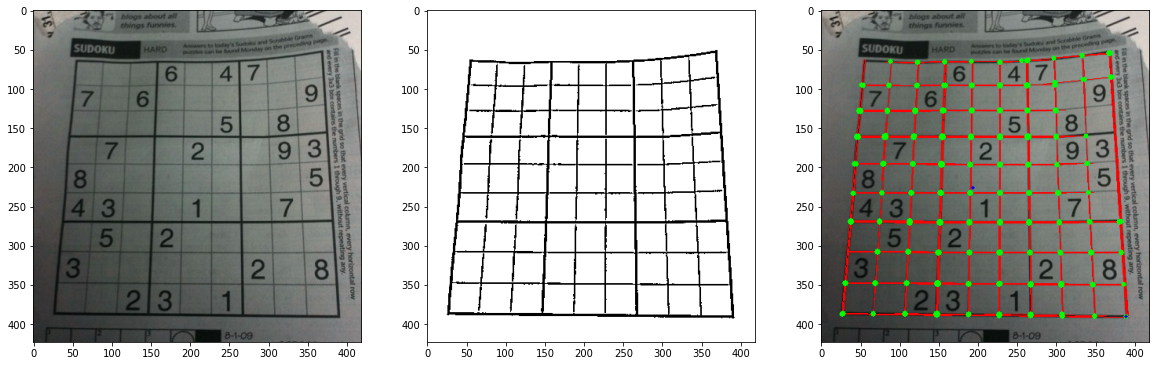

In [11]:
img = cv2.imread(os.path.join(base_data,'book_7.jpg'))
label_7 = get_res(img)

# CNN approach for grid detection

In [12]:
# network params
BatchSize = 4
NumChannels = 3
ImgHeight, ImgWidth = 480, 640
NumClass = 1

# data params
TrainImageDir = './data/train/img'
ValImageDir = './data/val/img'

In [13]:
model = seg_hrnet(BatchSize, ImgHeight, ImgWidth, NumChannels, NumClass)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=2)

model_path = "seg_hrnet-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}-{val_iou:.4f}.h5"
model_checkpoint = ModelCheckpoint(os.path.join('model',model_path), monitor='val_loss', mode='min', verbose=1, save_best_only=True)

check_point_list = [model_checkpoint, early_stop, reduce_lr]









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
train, train_steps = batch_generator(TrainImageDir, BatchSize, seed = 0, flag = 'train')
val, val_steps = batch_generator(ValImageDir, BatchSize, seed = 0, flag = 'val')

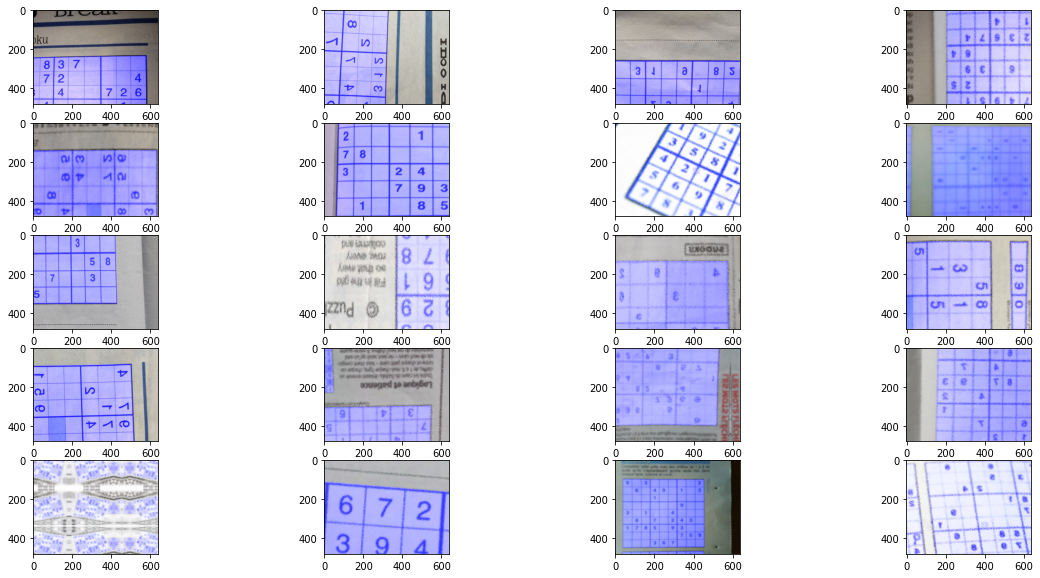

In [15]:
plt.figure(figsize=(20,10))
row = 5

for i in range(row):
    img, mask = next(train)
    for j in range(BatchSize):
        plt.subplot(row,BatchSize,i*BatchSize+j+1)
        image = cv2.cvtColor((img[j]* 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        gt = cv2.cvtColor((mask[j]* 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        plt.imshow(cv2.bitwise_or(image,gt))

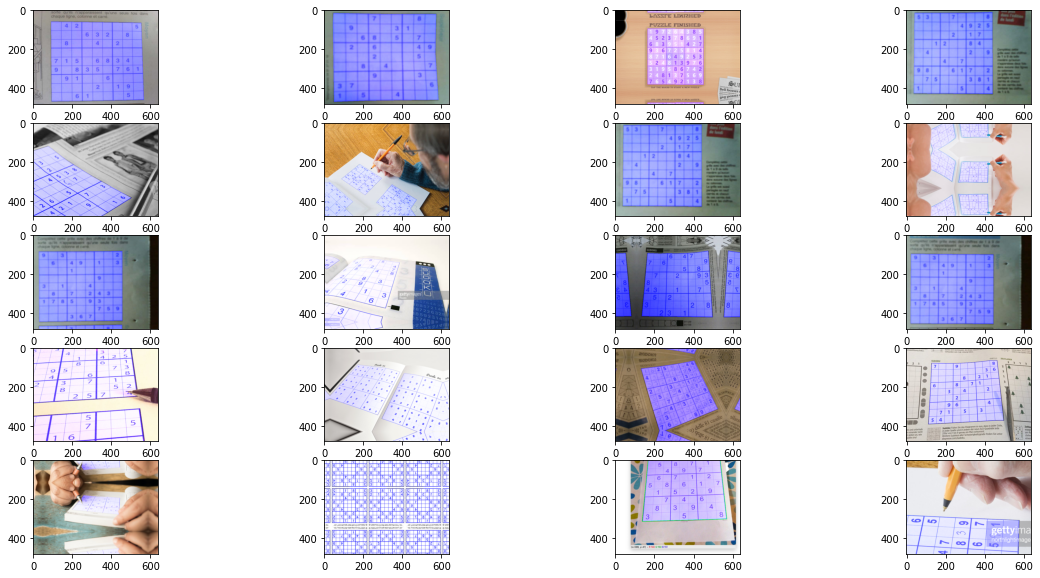

In [16]:
plt.figure(figsize=(20,10))

for i in range(row):
    img, mask = next(val)
    for j in range(BatchSize):
        plt.subplot(row,BatchSize,i*BatchSize+j+1)
        image = cv2.cvtColor((img[j]* 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        gt = cv2.cvtColor((mask[j]* 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        plt.imshow(cv2.bitwise_or(image,gt))

In [17]:
result = model.fit_generator(generator = train,
                             steps_per_epoch = train_steps,
                             epochs = 25,
                             verbose = 1,
                             validation_data = val,
                             validation_steps = val_steps,
                             callbacks = check_point_list)

Epoch 1/25


ValueError: Error when checking target: expected Classification to have shape (480, 640, 1) but got array with shape (480, 640, 3)

In [ ]:
plt.figure()
plt.plot(result.epoch, result.history['loss'], label="loss")
plt.plot(result.epoch, result.history['val_loss'], label="val_loss")
plt.legend(loc='upper right')
plt.show()